In [ ]:
import numpy as np
import pandas as pd
import os
import csv
import re
from dotenv import load_dotenv
import json
from openai import OpenAI
from sentence_transformers import SentenceTransformer
import glob
import PyPDF2 
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
from PyPDF2 import PdfReader
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import hashlib
from difflib import SequenceMatcher
import time

/home/cptaswadu/RESCUE-n8n/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = '/home/cptaswadu/RESCUE-n8n/insurance'
load_dotenv(dotenv_path=os.path.join(path, ".env"))
openai_api_key = os.getenv("OPEN_AI_API_KEY")

In [3]:
answer_policy_dir = "/home/cptaswadu/RESCUE-n8n/insurance/dataset/policy_answer"
for filename in os.listdir(answer_policy_dir):
    file_path = os.path.join(answer_policy_dir, filename)
    if os.path.isfile(file_path):
        with open(file_path, "rb") as f:
            content = f.read()
            md5_hash = hashlib.md5(content).hexdigest()
        print(f"{filename} => {md5_hash}")

Aetna_Breast and Ovarian Cancer Susceptibility Gene Testing, Prophylactic Mastectomy, and Prophylactic Oophorectomy - Medical Clinical Policy Bulletins.pdf => 853350c3473bcef32091186fbb7318fd
Aetna_Genetic Testing - Medical Clinical Policy Bulletins.pdf => af9f1086001f5b00ec242195723c10bf
United Healthcare_genetic-testing-cardiac-disease.pdf => f77e783d8f23d96b1932bc0f7cf7e8c7
Cigna_MOL.TS_.306.C_Whole_Genome_Sequencing_Cigna_eff01.01.2025_pub09.10.2024.pdf => 36bb5264dda1b2027dcdfdd32a714204
Cigna_MOL.TS_.238.A_BRCA_Analysis_eff01.01.2025_pub09.10.2024_1.pdf => 626eac4d60df057ea93ece78f8cc3dfc
United Healthcare_genetic-testing-hereditary-cancer.pdf => c69485372670ce1d12aa8f61d83a06fd
United Healthcare_genetic-testing-neuromuscular-disorders.pdf => 4dec1a815b8ecffdf00d34ad7f04836f
CapitalBC_BRCA.pdf => 34dc0823a03ca2f20ba740345d7b57da
United Healthcare_whole-exome-and-whole-genome-sequencing.pdf => 4fadf6b3ca9d4d08131cb31365e3aa7d
Cigna_MOL.TS_.235.C_Whole_Exome_Sequencing_Cigna_eff01.

In [ ]:
def add_md5_from_answer_key(patient_data_file, answer_key_file, output_file):
    """
    Add the expected_md5 information from the answer sheet to the patient data.
    """
    
    # Load patient data
    with open(patient_data_file, 'r', encoding='utf-8') as f:
        patient_data = json.load(f)
    
    # Load answer key
    with open(answer_key_file, 'r', encoding='utf-8') as f:
        answer_key = json.load(f)
    
    # Add MD5 information to patient data
    updated_patient_data = []
    for patient in patient_data:
        case_id = patient['id']
        
        if case_id in answer_key and 'expected_md5' in answer_key[case_id]:
            patient['policy_md5'] = answer_key[case_id]['expected_md5']
            print(f"✅ {case_id}: MD5 정보 추가됨 ({answer_key[case_id]['expected_md5'][:8]}...)")
        else:
            print(f"❌ {case_id}: MD5 정보를 찾을 수 없음")
        
        updated_patient_data.append(patient)
    
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(updated_patient_data, f, indent=2, ensure_ascii=False)
    
    print(f"\n📁 결과가 {output_file}에 저장되었습니다.")
    return updated_patient_data

updated_data = add_md5_from_answer_key(
    patient_data_file="/home/cptaswadu/RESCUE-n8n/insurance/dataset/case_ex.json",    
    answer_key_file="/home/cptaswadu/RESCUE-n8n/insurance/dataset/ground_truth.json",      
    output_file="/home/cptaswadu/RESCUE-n8n/insurance/dataset/case_ex_md5.json"
)

print("\n=== 업데이트된 데이터 미리보기 ===")
for case in updated_data[:2]: 
    print(f"Case ID: {case['id']}")
    print(f"Policy MD5: {case.get('policy_md5', 'NOT FOUND')}")
    print("-" * 50)

✅ Case1: MD5 정보 추가됨 (4fadf6b3...)
✅ Case2: MD5 정보 추가됨 (af9f1086...)
✅ Case3: MD5 정보 추가됨 (ad2eb3a7...)
✅ Case4: MD5 정보 추가됨 (a73b8a2c...)
✅ Case5: MD5 정보 추가됨 (af9f1086...)
✅ Case6: MD5 정보 추가됨 (4fadf6b3...)
✅ Case7: MD5 정보 추가됨 (4fadf6b3...)
✅ Case8: MD5 정보 추가됨 (af9f1086...)
✅ Case9: MD5 정보 추가됨 (ad2eb3a7...)
✅ Case10: MD5 정보 추가됨 (a73b8a2c...)
✅ Case11: MD5 정보 추가됨 (af9f1086...)
✅ Case12: MD5 정보 추가됨 (4fadf6b3...)
✅ Case13: MD5 정보 추가됨 (4fadf6b3...)
✅ Case14: MD5 정보 추가됨 (af9f1086...)
✅ Case15: MD5 정보 추가됨 (36bb5264...)
✅ Case16: MD5 정보 추가됨 (a73b8a2c...)
✅ Case17: MD5 정보 추가됨 (4fadf6b3...)
✅ Case18: MD5 정보 추가됨 (af9f1086...)
✅ Case19: MD5 정보 추가됨 (36bb5264...)
✅ Case20: MD5 정보 추가됨 (af9f1086...)
✅ Case21: MD5 정보 추가됨 (853350c3...)
✅ Case22: MD5 정보 추가됨 (853350c3...)
✅ Case23: MD5 정보 추가됨 (853350c3...)
✅ Case24: MD5 정보 추가됨 (853350c3...)
✅ Case25: MD5 정보 추가됨 (c6948537...)
✅ Case26: MD5 정보 추가됨 (c6948537...)
✅ Case27: MD5 정보 추가됨 (853350c3...)
✅ Case28: MD5 정보 추가됨 (853350c3...)
✅ Case29: MD5 정보 추가됨 (c694853

In [ ]:
class QnAExecutorWithPDF:
    uploaded_files_cache = {}
    def __init__(self, questions_list, llm_model="chatgpt", openai_api_key=None):
        self.questions_list = questions_list
        self.formatted_questions = self.format_questions()
        self.llm_model = llm_model
        self.openai_api_key = openai_api_key
        

        if openai_api_key:
            from openai import OpenAI
            self.openai_client = OpenAI(api_key=openai_api_key)
        else:
            self.openai_client = None

        self.pdf_base_path = "/home/cptaswadu/RESCUE-n8n/insurance/dataset/policy_answer"

        self.md5_to_pdf = {
            "853350c3473bcef32091186fbb7318fd": "Aetna_Breast and Ovarian Cancer Susceptibility Gene Testing, Prophylactic Mastectomy, and Prophylactic Oophorectomy - Medical Clinical Policy Bulletins.pdf",
            "af9f1086001f5b00ec242195723c10bf": "Aetna_Genetic Testing - Medical Clinical Policy Bulletins.pdf",
            "f77e783d8f23d96b1932bc0f7cf7e8c7": "United Healthcare_genetic-testing-cardiac-disease.pdf",
            "36bb5264dda1b2027dcdfdd32a714204": "Cigna_MOL.TS_.306.C_Whole_Genome_Sequencing_Cigna_eff01.01.2025_pub09.10.2024.pdf",
            "626eac4d60df057ea93ece78f8cc3dfc": "Cigna_MOL.TS_.238.A_BRCA_Analysis_eff01.01.2025_pub09.10.2024_1.pdf",
            "c69485372670ce1d12aa8f61d83a06fd": "United Healthcare_genetic-testing-hereditary-cancer.pdf",
            "4dec1a815b8ecffdf00d34ad7f04836f": "United Healthcare_genetic-testing-neuromuscular-disorders.pdf",
            "34dc0823a03ca2f20ba740345d7b57da": "CapitalBC_BRCA.pdf",
            "4fadf6b3ca9d4d08131cb31365e3aa7d": "United Healthcare_whole-exome-and-whole-genome-sequencing.pdf",
            "ad2eb3a750b767e32ff847032f0e8e03": "Cigna_MOL.TS_.235.C_Whole_Exome_Sequencing_Cigna_eff01.01.2025_pub09.20.2024.pdf",
            "a73b8a2ce768f28198cd9450f3858945": "CapitalBC_whole-exome-and-whole-genome-sequencing-for-diagnosis-of-genetic-disorders.pdf"
        }

    def get_pdf_path_from_case(self, case_data):
        if 'policy_md5' not in case_data:
            raise ValueError(f"Case {case_data.get('id', 'Unknown')} does not have 'policy_md5' field")
        md5_hash = case_data['policy_md5']
        if md5_hash not in self.md5_to_pdf:
            raise ValueError(f"MD5 hash {md5_hash} not found")
        pdf_filename = self.md5_to_pdf[md5_hash]
        pdf_path = os.path.join(self.pdf_base_path, pdf_filename)
        if not os.path.exists(pdf_path):
            raise FileNotFoundError(f"PDF file is not existing: {pdf_path}")
        print(f"✅ {case_data['id']}: Found PDF - {pdf_filename} - {md5_hash}")
        return pdf_path, md5_hash

    def upload_pdf_to_openai(self, pdf_path):
        if md5_hash in self.uploaded_files_cache:
            cached_file_id = self.uploaded_files_cache[md5_hash]
            print(f"✅ Utilizing cached file: {cached_file_id} (MD5: {md5_hash})")
            return cached_file_id
        
        try:
            with open(pdf_path, "rb") as file:
                uploaded_file = self.openai_client.files.create(
                    file=file,
                    purpose="assistants"
                )
            self.uploaded_files_cache[md5_hash] = uploaded_file.id
            print(f"✅ OpenAI upload successed: {uploaded_file.id} (MD5: {md5_hash})")
            return uploaded_file.id
        except Exception as e:
            print(f"❗ OpenAI upload failed: {e}")
            raise e

    def format_question_block(self, q, indent=2):
        indent_str = " " * indent
        question_line = f"{q['question']}"
        if q.get("options") == ["Free text answer"]:
            question_line += f"\n{indent_str}(Free text answer allowed.)"
        else:
            question_line += f"\n{indent_str}Options: {', '.join(q['options'])}"
            if "additional_if_yes" in q:
                question_line += f"\n{indent_str}  If 'Yes':"
                for item in q["additional_if_yes"]:
                    if isinstance(item, str):
                        question_line += f"\n{indent_str}    - {item}"
                    elif isinstance(item, dict):
                        question_line += f"\n{indent_str}    - {self.format_question_block(item, indent + 6)}"
            if "additional_if_no" in q:
                question_line += f"\n{indent_str}  If 'No':"
                for item in q["additional_if_no"]:
                    if isinstance(item, str):
                        question_line += f"\n{indent_str}    - {item}"
                    elif isinstance(item, dict):
                        question_line += f"\n{indent_str}    - {self.format_question_block(item, indent + 6)}"
        return question_line

    def format_questions(self):
        return "\n\n".join([
            f"{q['id']}. {self.format_question_block(q)}"
            for q in self.questions_list
        ])

    def clean_json_response(self, response_text):
        original = response_text.strip()
        if "how can I assist you" in original.lower() or "insurance-related questions" in original.lower():
            raise ValueError("Perplexity returned generic assistant response instead of JSON.")
        try:
            return json.loads(original)
        except json.JSONDecodeError:
            pass

        if original.startswith("```") and original.endswith("```"):
            original = re.sub(r"^```(?:json)?\s*|\s*```$", "", original.strip(), flags=re.IGNORECASE).strip()

        try:
            return json.loads(original)
        except json.JSONDecodeError:
            pass
        
        match = re.search(r"(\{[\s\S]*?\})", original)
        if match:
            try:
                return json.loads(match.group(1))
            except json.JSONDecodeError:
                pass
        raise ValueError("No valid JSON found in the response.")

    def run_qna_with_pdf(self, case_data, qna_model="gpt4o"):
        """run QnA with PDF document using OpenAI API."""
        case_id = case_data['id']
        patient_info = case_data['patient_info']
        try:
            pdf_path, md5_hash = self.get_pdf_path_from_case(case_data)
            file_id = self.upload_pdf_to_openai(pdf_path, md5_hash)
            assistant = self.openai_client.beta.assistants.create(
                name="Insurance Policy Analyzer",
                instructions=f"""
You are a clinical insurance assistant specializing in genetic testing coverage policies.
You will be given:

1. Patient clinical information for answering questions.
2. Official insurance policy document text (strictly use this policy content for answering questions).

Focus on sections for uploaded policy document:
- **Medical necessity criteria**
- **Clinical guidelines** 
- **Prior authorization requirements**
- **Coverage criteria**

Patient Information:
{patient_info}

Based on the uploaded policy document and patient information, answer these questions:
{self.formatted_questions}

Output your answers in JSON format only, with no explanation.
Your response must follow this exact structure:
{{
  "Q0": "Whole Exome Sequencing (WES)",
  "Q1": "No",
  "Q2": "Yes",
  ...
  "Q4": "Yes",
  "Q4_followup": [
    {{
      "answer": "Yes",
      "followup": ["ACMG"]
    }}
  ],
  ...
  "Q9": "Yes",
  "Q9_followup": ["Yes"]
}}
""",
                model="gpt-4o",
                tools=[{"type": "file_search"}],
                tool_resources={"file_search": {"vector_stores": [{"file_ids": [file_id]}]}}
            )
            thread = self.openai_client.beta.threads.create()
            self.openai_client.beta.threads.messages.create(
                thread_id=thread.id,
                role="user",
                content="Please analyze the uploaded policy document and answer the questions."
            )
            run = self.openai_client.beta.threads.runs.create(
                thread_id=thread.id,
                assistant_id=assistant.id
            )
            while run.status in ["queued", "in_progress"]:
                time.sleep(1)
                run = self.openai_client.beta.threads.runs.retrieve(
                    thread_id=thread.id,
                    run_id=run.id
                )
            messages = self.openai_client.beta.threads.messages.list(
                thread_id=thread.id
            )
            result_content = messages.data[0].content[0].text.value
            print(f"\n=== {case_id} LLM Response ===")
            print(result_content)
            print("=" * 50)
            result_json = self.clean_json_response(result_content)
            final_result = {}
            for k, v in result_json.items():
                if "_selection" in k or "_details" in k:
                    base_key = k.replace("_selection", "").replace("_details", "")
                    final_result[f"{base_key}_followup"] = [v] if isinstance(v, str) else v
                else:
                    final_result[k] = v
                    
            folder_name = f"{qna_model}"
            save_dir = f"/home/cptaswadu/RESCUE-n8n/insurance/results/LLM_QnA/one_doc/{folder_name}"
            os.makedirs(save_dir, exist_ok=True)
            filename = os.path.join(save_dir, f"{case_id}_qna_result.json")
            with open(filename, "w") as f:
                json.dump(final_result, f, indent=2)
            print(f"✅ QnA result saved to {filename}")
            return final_result
        except Exception as e:
            print(f"❗ {case_id} Error during QnA: {e}")
            return None


In [27]:
def load_inputs(case_ex_path, ground_truth_path):
    with open(case_ex_path, "r") as f:
        case_ex = json.load(f)

    with open(ground_truth_path, "r") as f:
        ground_truth = json.load(f)

    return case_ex, ground_truth

case_path = "/home/cptaswadu/RESCUE-n8n/insurance/dataset/case_ex_md5.json"
truth_path = "/home/cptaswadu/RESCUE-n8n/insurance/dataset/ground_truth.json"

case_ex, ground_truth = load_inputs(case_path, truth_path)

In [5]:
questions_file_path = "/home/cptaswadu/RESCUE-n8n/insurance/dataset/Insurance_Genetic_Testing_QA.json"

with open(questions_file_path, "r") as f:
    questions_data = json.load(f)

questions_list = questions_data["questions"]

In [ ]:
executor = QnAExecutorWithPDF(
    questions_list=questions_list,
    llm_model="chatgpt", 
    openai_api_key=openai_api_key
)


qna_model = "gpt4o"

failed_cases = [] 

for case in case_ex:
    case_id = case["id"]
    try:
        result = executor.run_qna_with_pdf(
            case_data=case,
            qna_model=qna_model
        )
        
        if result and "error" not in result:
            print(f"✅ {case_id} Successfully executed QnA with {qna_model}.")
        else:
            raise ValueError(f"QnA failed: {result.get('error', 'Unknown error')}")
            
    except Exception as e:
        print(f"❌ Failed on {case_id} ({qna_model}): {e}")
        failed_cases.append({
            "case_id": case_id,
            "qna_model": qna_model,
            "error": str(e)
        })

✅ Case1: PDF 파일 찾음 - United Healthcare_whole-exome-and-whole-genome-sequencing.pdf
✅ OpenAI 업로드 완료: file-6r5spPHc95HzoJGCYmZqkm

=== Case1 LLM 원본 응답 ===
```json
{
  "Q0": "Whole Exome Sequencing (WES)",
  "Q1": "Yes",
  "Q2": "Yes",
  "Q3": "Yes",
  "Q4": "Yes",
  "Q4_followup": [
    {
      "answer": "Yes",
      "followup": ["ACMG"]
    }
  ],
  "Q5": "Yes",
  "Q6": "No",
  "Q7": "Yes",
  "Q8": "No",
  "Q9": "Yes",
  "Q9_followup": ["Yes"],
  "Q10": "No",
  "Q10_followup": "Diagnostic",
  "Q11": "Yes",
  "Q12": "Yes",
  "Q13": "Yes",
  "Q14": "Yes",
  "Q14_followup": "81415",
  "Q15": "No",
  "Q16": "Yes",
  "Q17": "To submit the claim, ensure that all necessary documentation is gathered, including genetic counseling notes, specialist's order, and previous test results like the chromosomal microarray test. Verify that the CPT code is correctly entered and that a pre-authorization, if needed, is obtained before submitting to United Healthcare."
}
```
✅ QnA result saved to /home/cptas

In [ ]:
# for 3 times iteration
for run_num in range(3): 
    print(f"\n🔄 Starting Run {run_num + 1}/3")
    
    executor = QnAExecutorWithPDF(
        questions_list=questions_list,
        llm_model="chatgpt", 
        openai_api_key=openai_api_key
    )

    qna_model = f"gpt4o_run{run_num + 1}"  
    failed_cases = [] 

    for case in case_ex:
        case_id = case["id"]
        try:
            result = executor.run_qna_with_pdf(
                case_data=case,
                qna_model=qna_model
            )
            
            if result and "error" not in result:
                print(f"✅ {case_id} Successfully executed QnA with {qna_model}.")
            else:
                raise ValueError(f"QnA failed : {result.get('error', 'Unknown error')}")
                
        except Exception as e:
            print(f"❌ Failed on {case_id} ({qna_model}): {e}")
            failed_cases.append({
                "case_id": case_id,
                "qna_model": qna_model,
                "error": str(e)
            })
    
    print(f"✅ Completed Run {run_num + 1}/3")


In [ ]:
executor = QnAExecutorWithPDF(
    questions_list=questions_list,
    llm_model="chatgpt", 
    openai_api_key=openai_api_key
)


qna_model = "gpt4o"

failed_cases = [] 

for case in case_ex:
    case_id = case["id"]
    try:
        result = executor.run_qna_with_pdf(
            case_data=case,
            qna_model=qna_model
        )
        
        if result and "error" not in result:
            print(f"✅ {case_id} Successfully executed QnA with {qna_model}.")
        else:
            raise ValueError(f"QnA failed : {result.get('error', 'Unknown error')}")
            
    except Exception as e:
        print(f"❌ Failed on {case_id} ({qna_model}): {e}")
        failed_cases.append({
            "case_id": case_id,
            "qna_model": qna_model,
            "error": str(e)
        })

✅ Case1: PDF 파일 찾음 - United Healthcare_whole-exome-and-whole-genome-sequencing.pdf
✅ OpenAI 업로드 완료: file-3SZy8HxVUdYrDnyhq7wsQs

=== Case1 LLM 원본 응답 ===
```json
{
  "Q0": "Whole Exome Sequencing (WES)",
  "Q1": "Not specified",
  "Q2": "Yes",
  "Q3": "Yes",
  "Q4": "Yes",
  "Q4_followup": [
    {
      "answer": "Yes",
      "followup": ["ACMG"]
    }
  ],
  "Q5": "Yes",
  "Q6": "No",
  "Q7": "Yes",
  "Q8": "No",
  "Q9": "Yes",
  "Q9_followup": ["Yes"],
  "Q10": "No",
  "Q10_followup": "Diagnostic",
  "Q11": "Yes",
  "Q12": "Yes",
  "Q13": "Yes",
  "Q14": "Yes",
  "Q14_followup": "81415",
  "Q15": "No",
  "Q16": "Yes",
  "Q17": "Prior authorization is required. Submit the claim with supporting medical records documentation demonstrating the patient's eligibility criteria according to the policy guidelines."
}
```
✅ QnA result saved to /home/cptaswadu/RESCUE-n8n/insurance/results/LLM_QnA/one_doc/gpt4o/Case1_qna_result.json
✅ Case1 성공적으로 처리됨
✅ Case2: PDF 파일 찾음 - Aetna_Genetic Testing - M

In [ ]:
def merge_qna_jsons_to_csv(folder_path):
    """Merge all QnA JSON results in a specific folder into a single CSV"""
    all_data = []

    # Check all files in the folder
    for file in os.listdir(folder_path):
        if file.endswith("_qna_result.json"):
            # Extract case_id (case123_qna_result.json -> case123)
            case_id = file.replace("_qna_result.json", "")
            json_path = os.path.join(folder_path, file)

            try:
                with open(json_path, "r", encoding='utf-8') as f:
                    result = json.load(f)
                    
                # Flatten each JSON result
                flat_result = {"case_id": case_id}
                
                for k, v in result.items():
                    if isinstance(v, list):
                        # Convert list to string separated by semicolons
                        flat_result[k] = "; ".join(map(str, v))
                    elif isinstance(v, dict):
                        # Convert dictionary to string
                        flat_result[k] = str(v)
                    else:
                        flat_result[k] = v

                all_data.append(flat_result)
                print(f"✅ Processed: {file}")
                
            except Exception as e:
                print(f"❗ Failed to parse {file}: {e}")

    # Save as CSV file
    if all_data:
        df = pd.DataFrame(all_data)
        
        # Natural sort by case_id (case1, case2, ..., case10, case11)
        def natural_sort_key(case_id):
            # Extract number from case123 -> 123
            numbers = re.findall(r'\d+', case_id)
            return int(numbers[0]) if numbers else 0
        
        df['sort_key'] = df['case_id'].apply(natural_sort_key)
        df = df.sort_values('sort_key').drop('sort_key', axis=1)
        
        # Define desired column order
        desired_columns = [
            'case_id', 'Q0', 'Q1', 'Q2', 'Q3', 'Q4', 'Q4_followup', 
            'Q5', 'Q6', 'Q7', 'Q8', 'Q8_followup', 'Q9', 'Q9_followup', 
            'Q10', 'Q10_followup', 'Q11', 'Q11_followup', 'Q12', 'Q13', 
            'Q14', 'Q14_followup', 'Q15', 'Q15_followup', 'Q16', 'Q17'
        ]
        
        # Select only existing columns
        existing_columns = [col for col in desired_columns if col in df.columns]
        
        # Reorder columns in desired order
        df = df[existing_columns]
        
        # Set CSV filename based on folder name
        folder_name = os.path.basename(folder_path)
        output_csv_path = os.path.join("/home/cptaswadu/RESCUE-n8n/insurance/results/LLM_QnA/one_doc", f"{folder_name}_merged_results.csv")
        
        df.to_csv(output_csv_path, index=False, encoding='utf-8-sig')

        print(f"\n✅ Successfully merged {len(all_data)} files!")
        print(f"📁 CSV saved to: {output_csv_path}")
        print(f"📊 Total records: {len(all_data)}")
        print(f"📋 Columns in order: {list(df.columns)}")
        
        return output_csv_path
    else:
        print(f"⚠️ No valid QnA result files found in: {folder_path}")
        return None

folder_path = "/home/cptaswadu/RESCUE-n8n/insurance/results/LLM_QnA/one_doc/gpt4o"
merge_qna_jsons_to_csv(folder_path)

✅ Processed: Case10_qna_result.json
✅ Processed: Case7_qna_result.json
✅ Processed: Case44_qna_result.json
✅ Processed: Case33_qna_result.json
✅ Processed: Case37_qna_result.json
✅ Processed: Case42_qna_result.json
✅ Processed: Case34_qna_result.json
✅ Processed: Case11_qna_result.json
✅ Processed: Case14_qna_result.json
✅ Processed: Case2_qna_result.json
✅ Processed: Case9_qna_result.json
✅ Processed: Case1_qna_result.json
✅ Processed: Case3_qna_result.json
✅ Processed: Case49_qna_result.json
✅ Processed: Case47_qna_result.json
✅ Processed: Case17_qna_result.json
✅ Processed: Case13_qna_result.json
✅ Processed: Case32_qna_result.json
✅ Processed: Case43_qna_result.json
✅ Processed: Case19_qna_result.json
✅ Processed: Case4_qna_result.json
✅ Processed: Case20_qna_result.json
✅ Processed: Case5_qna_result.json
✅ Processed: Case38_qna_result.json
✅ Processed: Case22_qna_result.json
✅ Processed: Case30_qna_result.json
✅ Processed: Case15_qna_result.json
✅ Processed: Case31_qna_result.json

'/home/cptaswadu/RESCUE-n8n/insurance/results/LLM_QnA/one_doc/gpt4o_merged_results.csv'

In [ ]:
#for 3 times iteration
for run_num in range(3):
    folder_path = f"/home/cptaswadu/RESCUE-n8n/insurance/results/LLM_QnA/one_doc/gpt4o_run{run_num + 1}"
    merge_qna_jsons_to_csv(folder_path)

In [ ]:
def fuzzy_match(pred, gold, threshold=0.8):
    """fuzzy matching for Q0"""
    from difflib import SequenceMatcher
    return SequenceMatcher(None, pred.lower(), gold.lower()).ratio() >= threshold

In [ ]:
def evaluate_csv_results(csv_path, gold_answers, output_dir):
    """Evaluate the results from a CSV file against gold standard answers."""
    
    df_results = pd.read_csv(csv_path)
    os.makedirs(output_dir, exist_ok=True)
    
    case_level_stats = []
    
    print(f"🔄 Evaluating {len(df_results)} cases from {csv_path}")
    
    for _, row in df_results.iterrows():
        case_id = row['case_id']
        
        gold_result = gold_answers.get(case_id)
        if gold_result is None:
            print(f"⚠️ No gold standard found for {case_id}")
            continue
        
        predicted_result = row.to_dict()
        
        correct_count = 0
        total_count = 0
        question_scores = []
        
        for qid in gold_result:
            if not qid.startswith("Q") or qid in {"policy_url", "Q17", "match", "expected_md5"} or "_followup" in qid:
                continue
            
            pred_answer = predicted_result.get(qid, "")
            gold_answer = gold_result.get(qid, "")
            
            if pred_answer is None or (isinstance(pred_answer, float) and np.isnan(pred_answer)):
                pred_answer = ""
            if isinstance(pred_answer, list):
                pred_answer = ", ".join(map(str, pred_answer))
            if isinstance(gold_answer, list):
                gold_answer = ", ".join(map(str, gold_answer))
            
            pred_answer = str(pred_answer).strip()
            gold_answer = str(gold_answer).strip()
            
            if qid == "Q0":
                is_correct = fuzzy_match(pred_answer, gold_answer)
            else:
                is_correct = pred_answer == gold_answer
            
            score = 1 if is_correct else 0
            question_scores.append(score)
            total_count += 1
            correct_count += score
            
            followup_key = qid + "_followup"
            if followup_key in gold_result and gold_result[followup_key] is not None:
                pred_followup = predicted_result.get(followup_key, None)
                gold_followup = gold_result.get(followup_key, None)
                
                if is_correct:
                    def normalize_followup(ans):
                        if ans is None:
                            return "None"
                        try:
                            if isinstance(ans, float) and np.isnan(ans):
                                return "None"
                        except (TypeError, ValueError):
                            pass
                        if ans == "":
                            return "None"
                        if isinstance(ans, list):
                            return ", ".join([str(a) for a in ans])
                        return str(ans)
                    
                    pred_followup_norm = normalize_followup(pred_followup)
                    gold_followup_norm = normalize_followup(gold_followup)
                    
                    pred_set = set(pred_followup_norm.split(", "))
                    gold_set = set(gold_followup_norm.split(", "))
                    
                    if gold_set == {"None"}:
                        followup_score = 1 if pred_set == {"None"} else 0
                    elif pred_set == {"None"}:
                        followup_score = 0
                    else:
                        intersection = pred_set & gold_set
                        followup_score = 1 if intersection else 0
                    question_scores.append(followup_score)
                    total_count += 1
                    correct_count += followup_score
        
        accuracy = correct_count / total_count * 100 if total_count > 0 else 0
        
        case_stats = {
            "case_id": case_id,
            "accuracy": accuracy,
            "correct_count": correct_count,
            "total_count": total_count
        }
        
        case_level_stats.append(case_stats)
        print(f"✅ {case_id}: {accuracy:.2f}% accuracy")
    
    if case_level_stats:
        case_df = pd.DataFrame(case_level_stats)
        case_csv_path = os.path.join(output_dir, "case_level_statistics.csv")
        case_df.to_csv(case_csv_path, index=False)
        print(f"✅ Case-level statistics saved to: {case_csv_path}")
        
        all_accuracies = case_df["accuracy"].values
        overall_stats = {
            "total_cases": len(case_level_stats),
            "mean_accuracy": all_accuracies.mean(),
            "std_accuracy": all_accuracies.std(),
            "min_accuracy": all_accuracies.min(),
            "max_accuracy": all_accuracies.max(),
            "median_accuracy": np.median(all_accuracies),
            "q25_accuracy": np.percentile(all_accuracies, 25),
            "q75_accuracy": np.percentile(all_accuracies, 75)
        }
        
        overall_df = pd.DataFrame([overall_stats])
        overall_csv_path = os.path.join(output_dir, "overall_statistics.csv")
        overall_df.to_csv(overall_csv_path, index=False)
        print(f"✅ Overall statistics saved to: {overall_csv_path}")
        
        print(f"\n📊 Evaluation Summary:")
        print(f"Total cases evaluated: {overall_stats['total_cases']}")
        print(f"Mean accuracy: {overall_stats['mean_accuracy']:.2f}%")
        print(f"Standard deviation: {overall_stats['std_accuracy']:.2f}%")
        print(f"Min accuracy: {overall_stats['min_accuracy']:.2f}%")
        print(f"Max accuracy: {overall_stats['max_accuracy']:.2f}%")
        print(f"Median accuracy: {overall_stats['median_accuracy']:.2f}%")
        
        return case_df, overall_df
    
    return None, None
                    


In [38]:
output_dir = "/home/cptaswadu/RESCUE-n8n/insurance/results/LLM_QnA/one_doc"
csv_path = "/home/cptaswadu/RESCUE-n8n/insurance/results/LLM_QnA/one_doc/gpt4o_merged_results.csv"
evaluate_csv_results(csv_path, ground_truth, output_dir)

🔄 Evaluating 45 cases from /home/cptaswadu/RESCUE-n8n/insurance/results/LLM_QnA/one_doc/gpt4o_merged_results.csv
✅ Case1: 90.48% accuracy
✅ Case2: 71.43% accuracy
✅ Case3: 95.24% accuracy
✅ Case4: 85.71% accuracy
✅ Case5: 80.95% accuracy
✅ Case7: 85.71% accuracy
✅ Case8: 66.67% accuracy
✅ Case9: 66.67% accuracy
✅ Case10: 76.19% accuracy
✅ Case11: 65.00% accuracy
✅ Case12: 65.00% accuracy
✅ Case13: 80.95% accuracy
✅ Case14: 85.00% accuracy
✅ Case15: 90.00% accuracy
✅ Case16: 90.00% accuracy
✅ Case17: 75.00% accuracy
✅ Case18: 65.00% accuracy
✅ Case19: 76.19% accuracy
✅ Case20: 63.16% accuracy
✅ Case21: 95.24% accuracy
✅ Case22: 75.00% accuracy
✅ Case24: 85.71% accuracy
✅ Case26: 85.71% accuracy
✅ Case28: 70.00% accuracy
✅ Case29: 75.00% accuracy
✅ Case30: 70.00% accuracy
✅ Case31: 85.71% accuracy
✅ Case32: 95.24% accuracy
✅ Case33: 80.00% accuracy
✅ Case34: 70.00% accuracy
✅ Case35: 80.95% accuracy
✅ Case36: 85.71% accuracy
✅ Case37: 70.00% accuracy
✅ Case38: 55.00% accuracy
✅ Case40: 7

(   case_id   accuracy  correct_count  total_count
 0    Case1  90.476190             19           21
 1    Case2  71.428571             15           21
 2    Case3  95.238095             20           21
 3    Case4  85.714286             18           21
 4    Case5  80.952381             17           21
 5    Case7  85.714286             18           21
 6    Case8  66.666667             14           21
 7    Case9  66.666667             14           21
 8   Case10  76.190476             16           21
 9   Case11  65.000000             13           20
 10  Case12  65.000000             13           20
 11  Case13  80.952381             17           21
 12  Case14  85.000000             17           20
 13  Case15  90.000000             18           20
 14  Case16  90.000000             18           20
 15  Case17  75.000000             15           20
 16  Case18  65.000000             13           20
 17  Case19  76.190476             16           21
 18  Case20  63.157895         

In [ ]:
# for 3 times iteration
for run_num in range(3):
    csv_path = f"/home/cptaswadu/RESCUE-n8n/insurance/results/LLM_QnA/one_doc/gpt4o_run{run_num + 1}_merged_results.csv"
    output_dir = f"/home/cptaswadu/RESCUE-n8n/insurance/results/LLM_QnA/one_doc/evaluation_run{run_num + 1}"
    
    evaluate_csv_results(csv_path, ground_truth, output_dir)
    


In [ ]:
def analyze_robustness(base_path):
    """Analyze robustness across multiple runs"""
    all_run_stats = []
    
    for run_num in range(3):
        stats_path = f"{base_path}/evaluation_run{run_num + 1}/overall_statistics.csv"
        if os.path.exists(stats_path):
            run_stats = pd.read_csv(stats_path)
            run_stats['run'] = run_num + 1
            all_run_stats.append(run_stats)
        else:
            print(f"⚠️ Stats file not found for run {run_num + 1}")
    
    if all_run_stats:
        combined_stats = pd.concat(all_run_stats, ignore_index=True)
        robustness_path = f"{base_path}/robustness_analysis.csv"
        combined_stats.to_csv(robustness_path, index=False)
        
        mean_accuracies = combined_stats['mean_accuracy'].values
        
        print(f"\n📊 Robustness Analysis:")
        print(f"Run 1 Mean Accuracy: {mean_accuracies[0]:.2f}%")
        print(f"Run 2 Mean Accuracy: {mean_accuracies[1]:.2f}%") 
        print(f"Run 3 Mean Accuracy: {mean_accuracies[2]:.2f}%")
        print(f"Overall Mean: {mean_accuracies.mean():.2f}%")
        print(f"Standard Deviation across runs: {mean_accuracies.std():.2f}%")
        print(f"Min-Max Range: {mean_accuracies.min():.2f}% - {mean_accuracies.max():.2f}%")
        
        if mean_accuracies.std() < 2.0:
            print("✅ High consistency (std < 2%)")
        elif mean_accuracies.std() < 5.0:
            print("⚠️ Moderate consistency (2% ≤ std < 5%)")
        else:
            print("❌ Low consistency (std ≥ 5%)")
            
        print(f"📁 Robustness analysis saved to: {robustness_path}")
        return combined_stats
    else:
        print("❌ No run statistics found for robustness analysis")
        return None

base_path = "/home/cptaswadu/RESCUE-n8n/insurance/results/LLM_QnA/one_doc"
robustness_stats = analyze_robustness(base_path)


In [ ]:
def create_evaluation_figures(case_df, overall_df, output_dir):
    """Create various evaluation figures based on the case_df and overall_df data."""
    
    # Font
    plt.rcParams['font.family'] = 'DejaVu Sans'
    
    # 1. Bar chart of accuracy by case
    plt.figure(figsize=(12, 6))
    case_df_sorted = case_df.sort_values('case_id', key=lambda x: x.str.extract('(\d+)').astype(int)[0])
    
    colors = ['#ff7f7f' if acc < 70 else '#ffb347' if acc < 80 else '#90EE90' for acc in case_df_sorted['accuracy']]
    
    bars = plt.bar(range(len(case_df_sorted)), case_df_sorted['accuracy'], 
                   color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
    
    # Add value labels on top of each bar
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=9)
    
    plt.xlabel('Case ID')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy by Case')
    plt.xticks(range(len(case_df_sorted)), case_df_sorted['case_id'], rotation=45)
    plt.ylim(0, 105)
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    
    bar_path = os.path.join(output_dir, "accuracy_by_case.png")
    plt.savefig(bar_path, dpi=300, bbox_inches='tight')
    print(f"📊 Case accuracy bar chart saved to: {bar_path}")
    plt.show()
    plt.close()
    
    # 2. Histogram of accuracy distribution
    plt.figure(figsize=(10, 6))
    plt.hist(case_df['accuracy'], bins=15, alpha=0.7, color='skyblue', 
             edgecolor='black', linewidth=0.5)
    
    mean_acc = case_df['accuracy'].mean()
    plt.axvline(mean_acc, color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {mean_acc:.1f}%')
    
    plt.xlabel('Accuracy (%)')
    plt.ylabel('Number of Cases')
    plt.title(f'Distribution of Case Accuracy\n(Mean: {mean_acc:.1f}%, Std: {case_df["accuracy"].std():.1f}%)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    hist_path = os.path.join(output_dir, "accuracy_distribution.png")
    plt.savefig(hist_path, dpi=300, bbox_inches='tight')
    print(f"📊 Accuracy distribution saved to: {hist_path}")
    plt.show()
    plt.close()
    
    # 3. Bar charts for correct and total question counts by case
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # 3-1. Bar chart for correct answers
    bars1 = ax1.bar(range(len(case_df_sorted)), case_df_sorted['correct_count'], color='lightgreen', alpha=0.8, edgecolor='black', linewidth=0.5)
    
    for i, bar in enumerate(bars1):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{int(height)}', ha='center', va='bottom', fontsize=9)
    
    ax1.set_xlabel('Case ID')
    ax1.set_ylabel('Correct Count')
    ax1.set_title('Number of Correct Answers by Case')
    ax1.set_xticks(range(len(case_df_sorted)))
    ax1.set_xticklabels(case_df_sorted['case_id'], rotation=45)
    ax1.grid(True, alpha=0.3, axis='y')
    
    # 3-2. Bar chart for total questions
    bars2 = ax2.bar(range(len(case_df_sorted)), case_df_sorted['total_count'], 
                    color='lightcoral', alpha=0.8, edgecolor='black', linewidth=0.5)
    
    for i, bar in enumerate(bars2):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{int(height)}', ha='center', va='bottom', fontsize=9)
    
    ax2.set_xlabel('Case ID')
    ax2.set_ylabel('Total Questions')
    ax2.set_title('Total Number of Questions by Case')
    ax2.set_xticks(range(len(case_df_sorted)))
    ax2.set_xticklabels(case_df_sorted['case_id'], rotation=45)
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    count_path = os.path.join(output_dir, "question_counts_by_case.png")
    plt.savefig(count_path, dpi=300, bbox_inches='tight')
    print(f"📊 Question counts chart saved to: {count_path}")
    plt.show()
    plt.close()
    
    # 4. Pie chart of performance categories
    plt.figure(figsize=(8, 6))
    
    high_perf = len(case_df[case_df['accuracy'] >= 85])
    mid_perf = len(case_df[(case_df['accuracy'] >= 70) & (case_df['accuracy'] < 85)])
    low_perf = len(case_df[case_df['accuracy'] < 70])
    
    labels = ['High (≥85%)', 'Medium (70-84%)', 'Low (<70%)']
    sizes = [high_perf, mid_perf, low_perf]
    colors = ['#90EE90', '#ffb347', '#ff7f7f']
    
    non_zero = [(label, size, color) for label, size, color in zip(labels, sizes, colors) if size > 0]
    if non_zero:
        labels, sizes, colors = zip(*non_zero)
        
        plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', 
                startangle=90, explode=[0.05]*len(sizes))
        plt.title('Performance Distribution by Category')
        plt.axis('equal')
        
        pie_path = os.path.join(output_dir, "performance_categories.png")
        plt.savefig(pie_path, dpi=300, bbox_inches='tight')
        print(f"📊 Performance categories pie chart saved to: {pie_path}")
        plt.show()
        plt.close()
    
    # 5. Overall evaluation summary
    plt.figure(figsize=(10, 6))
    plt.axis('off')
    
    stats_text = f"""
    📊 Overall Evaluation Statistics
    
    Total Cases Evaluated: {overall_df.iloc[0]['total_cases']}
    
    Accuracy Statistics:
    • Mean: {overall_df.iloc[0]['mean_accuracy']:.2f}%
    • Standard Deviation: {overall_df.iloc[0]['std_accuracy']:.2f}%
    • Minimum: {overall_df.iloc[0]['min_accuracy']:.2f}%
    • Maximum: {overall_df.iloc[0]['max_accuracy']:.2f}%
    • Median: {overall_df.iloc[0]['median_accuracy']:.2f}%
    • 25th Percentile: {overall_df.iloc[0]['q25_accuracy']:.2f}%
    • 75th Percentile: {overall_df.iloc[0]['q75_accuracy']:.2f}%
    
    Performance Categories:
    • High Performance (≥85%): {high_perf} cases
    • Medium Performance (70-84%): {mid_perf} cases
    • Low Performance (<70%): {low_perf} cases
    """
    
    plt.text(0.1, 0.5, stats_text, fontsize=12, verticalalignment='center',
             bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))
    
    plt.title('Evaluation Summary Statistics', fontsize=16, fontweight='bold', pad=20)
    
    summary_path = os.path.join(output_dir, "evaluation_summary.png")
    plt.savefig(summary_path, dpi=300, bbox_inches='tight')
    print(f"📊 Evaluation summary saved to: {summary_path}")
    plt.show()
    plt.close() 


<>:9: SyntaxWarning: invalid escape sequence '\d'
<>:9: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_791/1211121210.py:9: SyntaxWarning: invalid escape sequence '\d'
  case_df_sorted = case_df.sort_values('case_id', key=lambda x: x.str.extract('(\d+)').astype(int)[0])


🔄 Evaluating 45 cases from /home/cptaswadu/RESCUE-n8n/insurance/results/LLM_QnA/one_doc/gpt4o_merged_results.csv
✅ Case1: 90.48% accuracy
✅ Case2: 71.43% accuracy
✅ Case3: 95.24% accuracy
✅ Case4: 85.71% accuracy
✅ Case5: 80.95% accuracy
✅ Case7: 85.71% accuracy
✅ Case8: 66.67% accuracy
✅ Case9: 66.67% accuracy
✅ Case10: 76.19% accuracy
✅ Case11: 65.00% accuracy
✅ Case12: 65.00% accuracy
✅ Case13: 80.95% accuracy
✅ Case14: 85.00% accuracy
✅ Case15: 90.00% accuracy
✅ Case16: 90.00% accuracy
✅ Case17: 75.00% accuracy
✅ Case18: 65.00% accuracy
✅ Case19: 76.19% accuracy
✅ Case20: 63.16% accuracy
✅ Case21: 95.24% accuracy
✅ Case22: 75.00% accuracy
✅ Case24: 85.71% accuracy
✅ Case26: 85.71% accuracy
✅ Case28: 70.00% accuracy
✅ Case29: 75.00% accuracy
✅ Case30: 70.00% accuracy
✅ Case31: 85.71% accuracy
✅ Case32: 95.24% accuracy
✅ Case33: 80.00% accuracy
✅ Case34: 70.00% accuracy
✅ Case35: 80.95% accuracy
✅ Case36: 85.71% accuracy
✅ Case37: 70.00% accuracy
✅ Case38: 55.00% accuracy
✅ Case40: 7

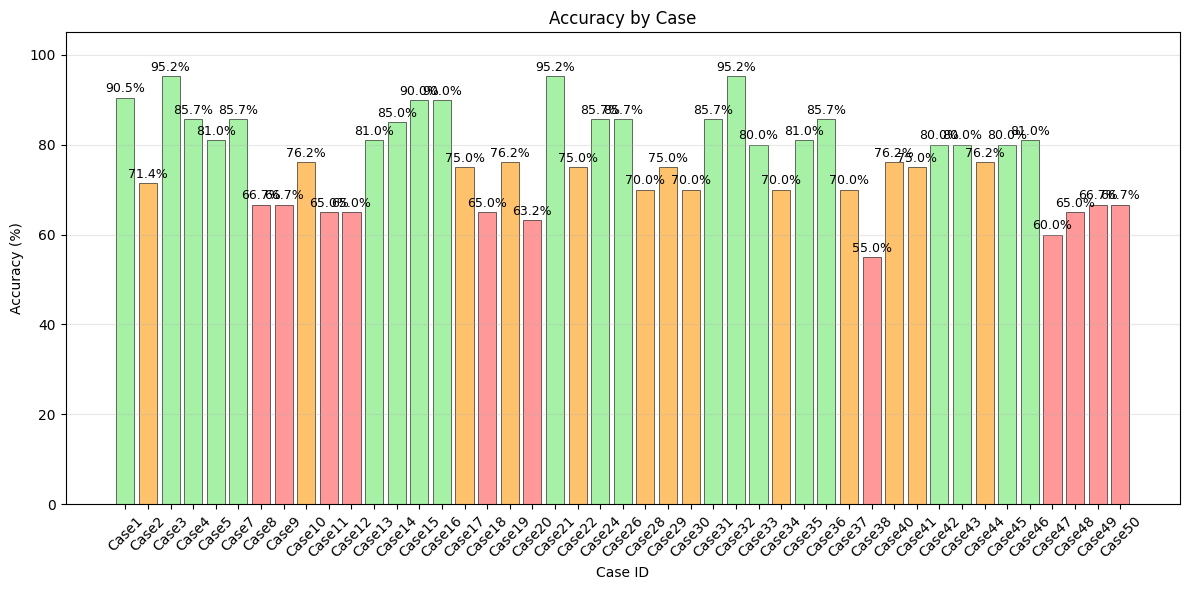

📊 Accuracy distribution saved to: /home/cptaswadu/RESCUE-n8n/insurance/results/LLM_QnA/one_doc/accuracy_distribution.png


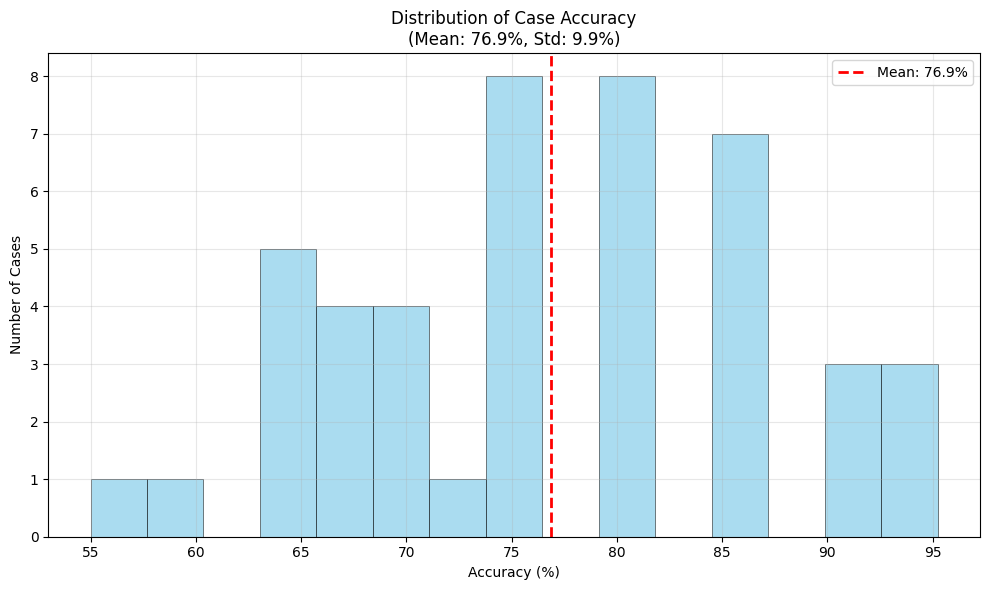

📊 Question counts chart saved to: /home/cptaswadu/RESCUE-n8n/insurance/results/LLM_QnA/one_doc/question_counts_by_case.png


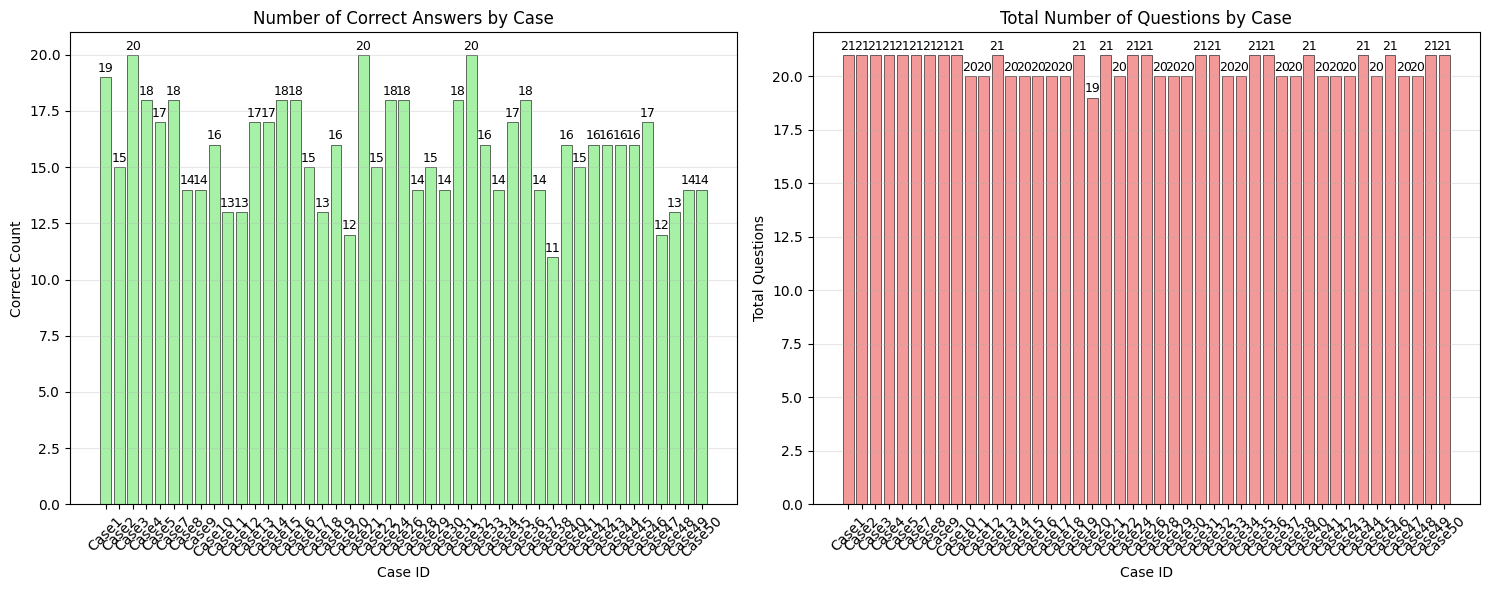

📊 Performance categories pie chart saved to: /home/cptaswadu/RESCUE-n8n/insurance/results/LLM_QnA/one_doc/performance_categories.png


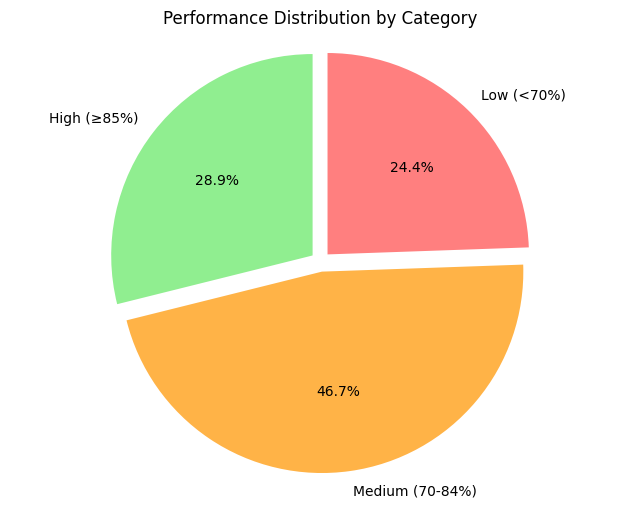

/tmp/ipykernel_791/1211121210.py:157: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig(summary_path, dpi=300, bbox_inches='tight')


📊 Evaluation summary saved to: /home/cptaswadu/RESCUE-n8n/insurance/results/LLM_QnA/one_doc/evaluation_summary.png


/home/cptaswadu/RESCUE-n8n/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


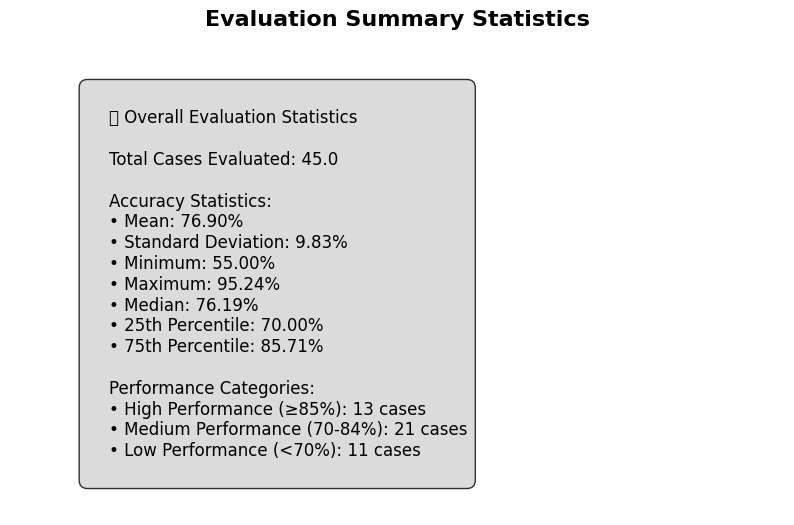

✅ All figures saved to: /home/cptaswadu/RESCUE-n8n/insurance/results/LLM_QnA/one_doc


In [ ]:
def evaluate_csv_results_with_figures(csv_path, gold_answers, output_dir):
    """Evaluate CSV results and generate visualization figures."""
    
    case_df, overall_df = evaluate_csv_results(csv_path, gold_answers, output_dir)
    
    if case_df is not None and overall_df is not None:
        print(f"\n🎨 Generating visualization figures...")
        create_evaluation_figures(case_df, overall_df, output_dir)
        print(f"✅ All figures saved to: {output_dir}")
    
    return case_df, overall_df


case_df, overall_df = evaluate_csv_results_with_figures(csv_path, ground_truth, output_dir)